# Lecture 9: FunSearch — Program Search with LLMs


In this seminar we explore **FunSearch**, a framework for mathematical discovery through program synthesis guided by large language models (LLMs), as introduced in [Romera-Paredes et al., *Nature* (2023)](https://www.nature.com/articles/s41586-023-06924-6). This approach is at it's simplest's outsorces thinking and improvements to LLMs!


## Goals:

- Understand the core idea of FunSearch
- Implement FunSearchLike algorithm
- Make an experiment and solve the simple math problem




## Setup

### Platform: _Nebius AI Studio_

- **Get an API key:** [studio.nebius.ai/settings/api-keys](https://studio.nebius.ai/settings/api-keys)  
- Save it at: `/MyDrive/API_keys/nebius_api_key` (no file extension)

---

### Optional: Try the Playground

Explore prompts interactively at  
[studio.nebius.ai/playground](https://studio.nebius.ai/playground)

In [ ]:
# === Colab Setup for Nebius + OpenAI-compatible client ===
# 1) Install deps
%pip install -q --upgrade openai tiktoken

# 2) Imports & deterministic seeding
import ast, os, sys, json, random, re, tiktoken
import numpy as np
import ipywidgets as w
import matplotlib.pyplot as plt

from abc import abstractmethod
from google.colab import drive
from IPython.display import display, clear_output
from openai import OpenAI
from textwrap import indent


SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 3) Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 4) Load Nebius API key from Drive (file with no extension)
KEY_PATH = "/content/drive/MyDrive/API_keys/nebius_api_key"
if not os.path.exists(KEY_PATH):
    raise FileNotFoundError(
        f"API key file not found at {KEY_PATH}. "
        "Create the file with your Nebius API key (single line, no quotes)."
    )

with open(KEY_PATH, "r") as f:
    NEBIUS_API_KEY = f.read().strip()

if not NEBIUS_API_KEY or len(NEBIUS_API_KEY) < 10:
    raise ValueError("Nebius API key seems empty or malformed.")

os.environ["NEBIUS_API_KEY"] = NEBIUS_API_KEY

# 6) Initialize OpenAI-compatible client for Nebius
NEBIUS_BASE_URL = os.environ.get("NEBIUS_BASE_URL", "https://api.studio.nebius.ai/v1/")
client = OpenAI(api_key=NEBIUS_API_KEY, base_url=NEBIUS_BASE_URL)

# 7) Smoke check (no network request)
print("Nebius client configured.")
print("Base URL:", NEBIUS_BASE_URL)
print("API key loaded (last 4 chars):", NEBIUS_API_KEY[-4:])

## Mini-Puzzle

**Task.** For a small number $n$ (e.g., 9), construct a set $A \subseteq \{1,2,\dots,n\}$ such that for any distinct $a,b\in A$ neither $a$ divides $b$ nor $b$ divides $a$.

1) Use the slider to pick $n$.  
2) **Predict** the best size $|A|$ you think is achievable.  
3) Click **Reveal baseline** to see a simple greedy baseline and compare it with your prediction.

> **Think:** What structural patterns help avoid divisibility? (e.g., primes? numbers packed in a tight range? avoiding powers?)

In [ ]:
n_slider   = w.IntSlider(value=9, min=1, max=11, step=1, description='n', readout=True)
guess_box  = w.BoundedIntText(value=3, min=0, max=200, description='Your guess |A|')
reveal_btn = w.Button(description='Reveal baseline', button_style='info')
out        = w.Output()

def greedy_antichain(n: int) -> list[int]:
    A = []
    for x in range(2, n + 1):
        ok = True
        for a in A:
            if x % a == 0 or a % x == 0:
                ok = False
                break
        if ok:
            A.append(x)
    return A

def show_set(A: list[int]) -> None:
    plt.figure(figsize=(7, 4.5))
    plt.grid(alpha=0.3)
    plt.scatter(range(len(A)), A, s=100, c="dodgerblue", edgecolors="k")
    plt.xlabel('Index in A', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title(f'Baseline set (|A| = {len(A)})', fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

def on_reveal(_):
    with out:
        clear_output(wait=True)
        n = n_slider.value
        guess = guess_box.value
        A = greedy_antichain(n)
        delta = len(A) - guess
        print(f"Your guess: {guess}; baseline: {len(A)}; difference: {delta:+d}\n")
        print(f"Baseline set A = {A}\n")
        show_set(A)
        print("Question: Can you think of a rule that would beat this baseline?")

reveal_btn.on_click(on_reveal)
display(w.VBox([w.HBox([n_slider, guess_box, reveal_btn]), out]))

### How does the baseline (greedy) algorithm work?


When you click **Reveal baseline**, the notebook runs a simple *greedy* algorithm:

1. Start with an empty set $A = \emptyset$.
2. Go through numbers $2, \dots, n$ in order.
3. For each candidate $x$:
   - If $x$ does **not** divide any element of $A$ and no element of $A$ divides $x$, then add $x$ into $A$.
   - Otherwise, skip $x$.

This builds a valid divisibility-free set step by step.  
It may not be the **largest possible** set, but it gives us a clear **baseline** to compare against.

## Naive Baseline (Greedy) and Why It Gets Stuck

**Greedy baseline (increasing order).**  
We scan numbers $2,3,\dots,n$ in order and add $x$ to $A$ if it doesn’t divide or isn’t divided by any element already in $A$.

Below you’ll see:
1. a **scatter** of the greedy set $A$ (index vs value), and  
2. a **conflict map** for $\{1,\dots,n\}$: a pixel at $(i,j)$ is dark if $i$ divides $j$ or $j$ divides $i$ (with $i\neq j$).  

Dense dark rows/columns (small numbers like $2,3,4,5,\dots$) show why early greedy choices can block many later elements.

> **Key issue:** early choices (like $2$ or $3$) may block many later numbers.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as w

# Widgets
n_slider = w.IntSlider(value=20, min=10, max=60, step=2, description='n')
run_btn  = w.Button(description='Run greedy baseline')

# Separate outputs to avoid overlap
out_text     = w.Output()
out_scatter  = w.Output()
out_heatmap  = w.Output()

def greedy_antichain_increasing(n: int) -> list[int]:
    A = []
    for x in range(2, n+1):  # skip 1 to avoid degenerate case
        if all((x % a != 0) and (a % x != 0) for a in A):
            A.append(x)
    return A

def rejection_witnesses(n: int, A: list[int]):
    rejections = []
    in_A = set(A)
    for x in range(2, n+1):
        if x not in in_A:
            for a in A:
                if x % a == 0 or a % x == 0:
                    rejections.append((x, a))
                    break
    return rejections

def run_greedy(n: int):
    # Clear all panels first
    out_text.clear_output()
    out_scatter.clear_output()
    out_heatmap.clear_output()

    # Compute baseline + small diagnostics
    A = greedy_antichain_increasing(n)
    rej = rejection_witnesses(n, A)

    # Text panel
    with out_text:
        print(f"Greedy baseline (increasing order)  |A| = {len(A)}")
        print(f"Set A: {A}")
        if rej:
            print("\nExamples of rejections (rejected → blocked by):")
            for x, b in rej[:5]:
                print(f"  {x} → {b}")
        else:
            print("\nNo rejections recorded (small n).")

    # Scatter panel
    with out_scatter:
        fig1 = plt.figure(figsize=(6, 3.2))
        plt.scatter(range(len(A)), A, s=80)
        plt.xlabel("index in A")
        plt.ylabel("value")
        plt.title(f"Greedy baseline — |A|={len(A)}")
        plt.tight_layout()
        plt.show()
        plt.close(fig1)  # ensure it doesn't leak into the next output

    # Heatmap panel (conflict map)
    with out_heatmap:
        M = np.zeros((n, n), dtype=int)
        for i in range(1, n+1):
            for j in range(1, n+1):
                if i != j and ((i % j == 0) or (j % i == 0)):
                    M[i-1, j-1] = 1

        fig2 = plt.figure(figsize=(4.2, 4.2))
        plt.imshow(M, cmap="Blues", interpolation="nearest")
        plt.title(f"Divisibility map 1..{n}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close(fig2)

def on_run(_):
    clear_output(wait=True)  # refresh the widget layout
    display(w.VBox([
        n_slider,
        run_btn,
        out_text,
        out_scatter,
        out_heatmap,
    ]))
    run_greedy(n_slider.value)

run_btn.on_click(on_run)
# initial layout
display(w.VBox([n_slider, run_btn, out_text, out_scatter, out_heatmap]))

## FunSearch Core Idea

**What is FunSearch?**  
We iteratively search over small programs (heuristics). Each round:
1) **Generate** candidate programs by mutating the current ones;  
2) **Evaluate** each program on the task with an automatic judge (a score);  
3) **Select** the top programs to keep (the “elite”) and repeat.

**Mini-pseudocode (8–10 lines):**
```text
# Core FunSearch loop (no API/SDK needed)
population ← init_random_programs(K)
best ← (None, -∞)

for t in 1..G:
    candidates ← population ∪ mutate(population) ∪ crossover(population)     # generate
    scored ← [ (p, evaluate(p, task)), for p in candidates ]                  # evaluate
    population ← select_top(scored, K)                                        # select
    best ← max(best, max(scored))                                             # track global best

return best.program
```

Notes:

-	Programs are short strategies/heuristics you allow (safe and deterministic).
- evaluate(p, task) runs p on fixed test cases and returns a numeric score.
-	The power comes from repeating this loop with small, steady improvements.

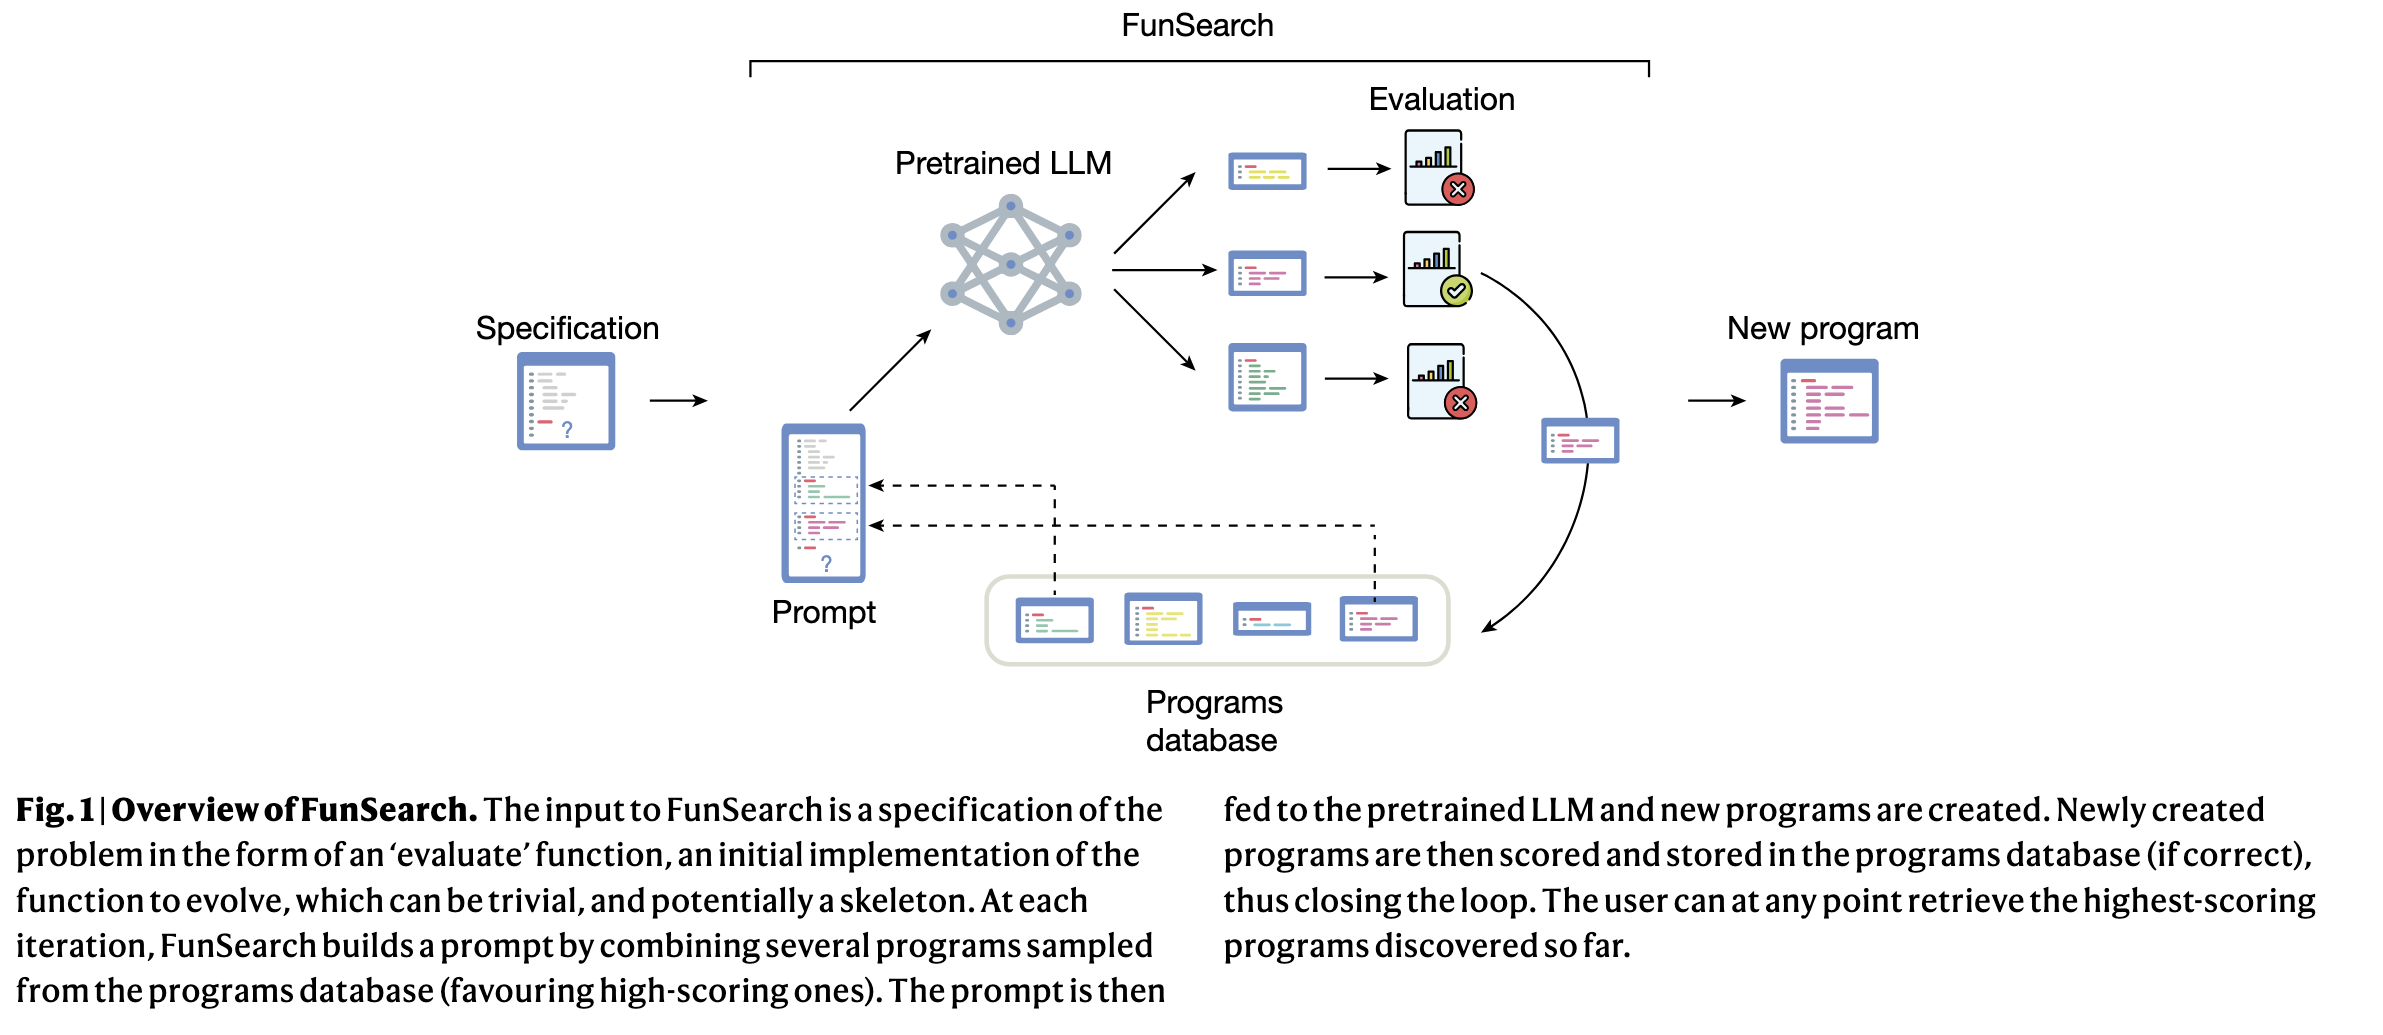

### What is a *Heuristic* in Our Context?

When we talk about **heuristics** here, we do **not** mean writing a full program that solves the entire problem.  
Instead, we focus on a **tiny piece of logic**: a *ranking function* that scores candidate elements (like numbers $x$) when we decide whether to add them to our set $A$.

---

### Why just a ranking function?

Imagine you are building the set $A$ step by step. At each step you face many candidates that could be added.  
Instead of trying to construct the entire optimal set in one shot (which is very hard), you only need a **rule of thumb** that says:

> *“Among all valid candidates, which one looks more promising?”*

This rule is our **heuristic**.

---

### Example Heuristics

- **Divisor count heuristic:** prefer numbers with *fewer divisors* (they are less likely to block others).  
- **Prime count heuristic:** prefer numbers with *fewer prime factors*.  
- **Modulo heuristic:** prefer numbers that satisfy a certain modular condition, e.g. $x \bmod 7$.  
- **Position heuristic:** prefer candidates depending on the *current size* of $A$ (e.g., alternate even/odd).

Each of these is a **small scoring function** $h(x, A)$ that gives a numeric score to candidate $x$ given the current set $A$.

---

### The FunSearch Perspective

In our FunSearch experiment, we don’t try to write one clever heuristic ourselves.  
Instead, we let the system:

1. **Start** with a pool of simple, sometimes silly heuristics;  
2. **Mutate** them randomly (e.g., swap “divisor count” with “prime count”, change a sign, add a modular condition);  
3. **Evaluate** them automatically by running the greedy construction with that scoring function;  
4. **Select** those that gave the largest $|A|$.

Over many rounds, this “evolution” may stumble on combinations of heuristics that are surprisingly effective — sometimes better than a carefully hand-crafted rule.

## Toy Evolutionary Loop (Not FunSearch) — *k* offsprings, *G* generations, leaderboard

We evolve **tiny heuristics** (ranking functions) instead of full solutions:

1) **Generate**: from a current heuristic, make *k* mutated variants  
2) **Evaluate**: for each heuristic, greedily build a set by *ranking* valid candidates and adding the best next one  
3) **Select**: keep the best heuristic (largest $|A|$); repeat for *G* generations

**Parameters**
- `n`: problem size (we build a divisibility-free set in $\{2,\dots,n\}$)  
- `k`: number of offsprings (mutations) per generation  
- `gens`: number of generations to run  
- `seed`: randomness control (reproducibility)

The **leaderboard** shows the best program name and $|A|$ per iteration.

In [ ]:
def h_divcount(x):
    """Number of divisors of x (smaller is often better)."""
    cnt, i = 0, 1
    while i*i <= x:
        if x % i == 0:
            cnt += 2 if i*i != x else 1
        i += 1
    return cnt

def h_primecount(x):
    """Prime factor count with multiplicity (smaller is often better)."""
    c, p, k = x, 2, 0
    while p*p <= c:
        while c % p == 0:
            c //= p
            k += 1
        p += 1
    if c > 1:
        k += 1
    return k

PRIMS = [
    ("-divcount",           lambda x, A: -h_divcount(x)),
    ("-primecount",         lambda x, A: -h_primecount(x)),
    ("+x%7",                lambda x, A:  (x % 7)),
    ("-(x%5)",              lambda x, A: -(x % 5)),
    ("+len(A)%3",           lambda x, A:  (len(A) % 3)),
]

def build_program(parts):
    """Combine 2 primitives into one scorer; return (name, scorer)."""
    assert 1 <= len(parts) <= 3
    name = " + ".join(p[0] for p in parts)
    def scorer(x, A):
        return sum(p[1](x, A) for p in parts)
    return name, scorer

# ---------- Greedy construction guided by a ranking function ----------
def construct_set_ranked(n, scorer):
    """Build A by repeatedly adding the valid candidate with the highest score."""
    A = []
    remaining = set(range(2, n+1))  # skip 1 to avoid degenerate case
    while True:
        valid = [x for x in remaining if all((x % a != 0) and (a % x != 0) for a in A)]
        if not valid:
            break
        x_best = max(valid, key=lambda x: scorer(x, A))
        A.append(x_best)
        remaining.remove(x_best)
    return A

def evaluate(n, program):
    """Return dict with program name, size, and (optionally) the set."""
    name, scorer = program
    A = construct_set_ranked(n, scorer)
    return {"iter": None, "size": len(A), "name": name, "A": A}

# ---------- Evolutionary loop (k offsprings, gens generations) ----------
def mutate(parts):
    """Replace one primitive with a different one (keep length=2)."""
    idx = random.randrange(len(parts))
    pool = [p for p in PRIMS if p not in parts]
    if not pool:
        return parts[:]  # nothing to swap
    new_parts = parts[:]
    new_parts[idx] = random.choice(pool)
    return new_parts

def evolutionary_search(n, k=2, gens=8, seed=0):
    random.seed(seed)
    parent = random.sample(PRIMS, 2)                 # start with 2 features
    best_eval = evaluate(n, build_program(parent))
    history = []
    # generation 0 (initial)
    e0 = best_eval.copy(); e0["iter"] = 0
    history.append(e0)

    for t in range(1, gens+1):
        candidates = [parent] + [mutate(parent) for _ in range(k)]
        scored = []
        for parts in candidates:
            res = evaluate(n, build_program(parts))
            res["iter"] = t
            scored.append((parts, res))
        # pick best this round
        parts_best, eval_best = max(scored, key=lambda pr: pr[1]["size"])
        if eval_best["size"] >= best_eval["size"]:
            parent = parts_best
            best_eval = eval_best
        history.append(best_eval.copy())

    # Build leaderboard
    df = pd.DataFrame([{"iter": h["iter"], "size": h["size"], "best_program": h["name"]} for h in history])
    return df, best_eval

# ---------- Minimal UI (compact, single-cell output) ----------
n_slider   = w.IntSlider(value=20, min=10, max=80, step=2, description='n', readout=True)
k_slider   = w.IntSlider(value=2,  min=1, max=6,  step=1, description='k')
gens_slider= w.IntSlider(value=8,  min=1, max=40, step=1, description='gens')
seed_box   = w.IntText(value=0, description='seed')
run_btn    = w.Button(description='Run evolution')
out        = w.Output()

def on_run(_):
    with out:
        clear_output(wait=True)
        df, best = evolutionary_search(
            n=n_slider.value,
            k=k_slider.value,
            gens=gens_slider.value,
            seed=seed_box.value
        )
        display(df.tail(10))  # compact leaderboard (last 10 iterations)
        print(f"\nBest |A| = {best['size']}")
        print(f"Best program: {best['name']}")
        # Uncomment to show the actual set (can be long):
        # print(f"A = {best['A']}")

run_btn.on_click(on_run)
display(w.VBox([w.HBox([n_slider, k_slider, gens_slider, seed_box, run_btn]), out]))

## How FunSearch Uses LLMs for Mutation

In our toy loop above, the **mutations** were simple swaps of primitive features:  
we replaced one scoring rule (like “–divcount”) with another (like “–primecount”).

**Real FunSearch is different.**  
Instead of hard-coded swaps, an **LLM** (Large Language Model) is used to *generate* these mutations:

- The LLM sees the **current best program** (a short Python function, or pseudocode).  
- It is asked to propose **variations** — sometimes by tweaking constants, changing conditions, or combining heuristics in a novel way.  
- These LLM-generated variants are then **evaluated automatically** on the task.  
- The best few are kept, and the cycle repeats.

---

### Why use an LLM?
- **Creativity**: LLMs can propose patterns humans or simple random swaps wouldn’t try.  
- **Flexibility**: They can mutate not only numeric constants, but also control flow, conditions, or combinations of heuristics.  
- **Automation**: The system doesn’t need a human in the loop — it generates, evaluates, and selects programs continuously.

---

> **In short:** Our toy loop shows the mechanics of *evolution by mutation + selection*.  
> In **FunSearch**, the “mutation” step is powered by an LLM, which acts as a generator of new candidate programs.  
> The rest (evaluation and selection) is exactly the same idea we just explored.

## When is FunSearch Useful?

Now that we have seen how FunSearch works (mutation → evaluation → selection),
it’s important to ask: **what kinds of problems are suitable for this method?**

FunSearch can (potentially) be effective when:

1. **Efficient evaluator** — we can quickly test candidate programs.  
2. **Smooth or rich scoring** — small program changes lead to informative score differences, guiding iterative improvement.  
3. **Prior structure** — some problem-specific information provides a strong starting point for the search.

---

### Examples from the original FunSearch paper
- **[Cap set problem](https://en.wikipedia.org/wiki/Cap_set)**:  
  A deep combinatorial problem in additive number theory, where FunSearch discovered new constructions.  

- **[Online bin packing](https://en.wikipedia.org/wiki/Bin_packing_problem)**:  
  A classic algorithmic optimization problem, where FunSearch improved heuristics for packing efficiency.  

---

> **Takeaway:** FunSearch shines where we have *cheap evaluation, incremental feedback, and some structure to exploit* — but the global solution space is too vast for brute force or purely manual design.

##  Simple FunSearch-like Example

The code below is a **teaching demo** of the FunSearch idea (generate → evaluate → select).  
It evolves **tiny heuristics** (ranking functions) that guide a greedy constructor for a divisibility-free set.

> **Note:** This is *not* the paper’s full system — it’s a compact, self-contained illustration for class use.  
> You can either (A) run this step-by-step demo, or (B) optionally pull a reference repo later.

In [ ]:
!git clone https://github.com/leocus/SimpleFunSearch.git

# Change into the repo directory
%cd SimpleFunSearch

# Optional: list contents
!ls -R

from SimpleFunSearch.evaluators import Evaluator

## Appendix: Rewritten Classes

In the original codebase, the **`Model`** and **`EvolutionaryLoop`** classes were different from our purposes, so we needed to **rewrite** them.

The full rewritten source code is kept in the next cell, but it is **collapsed by default**  
to avoid distracting from the main flow. You don’t need to open it unless you want to dive into implementation details.

Also we realised **`init_model`** and **`solve_problem`** functions there, for running the code from git repo

In [ ]:
class Model:
    """An interface for querying an LLM via http requests."""

    def __init__(self, model_url, model_name, key, system_prompt):
        """
        Initialize the interface with the model.
        Params:
            model_url: url for connecting to the model
            model_name: name of the model
            key: API key
            system_prompt: system prompt
        """
        self._model_url = model_url
        self._model_name = model_name
        self._key = key
        self._system_prompt = system_prompt


    def get_output(self, prompt):
        """Query the model and get the output."""
        client = OpenAI(
            base_url=self._model_url,
            api_key=os.environ.get(self._key),
        )

        # Which LLM to use
        # For more models, see https://docs.nebius.com/studio/inference/models/
        MODEL = self._model_name

        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                {
                    "role": "system",
                    "content": self._system_prompt
                },
                {
                    "role": "user",
                    "content": prompt
                },
            ],
            # What sampling temperature to use, between 0 and 2.
            # Higher values like 0.8 will make the output more random,
            # while lower values like 0.2 will make it more focused
            # and deterministic.
            # We generally recommend altering this or top_p but not both.
            temperature=1.0,

            # How many chat completion choices to generate for each
            # input message. Note that you will be charged based on
            # the number of generated tokens across all of the choices.
            # Keep n as 1 to minimize costs.
            n = 1,

            max_tokens=256,

            # Up to 4 sequences where the API will stop generating further tokens.
            # The returned text will not contain the stop sequence.
            stop = [],

            # An alternative to sampling with temperature, called
            # nucleus sampling, where the model considers the
            # results of the tokens with top_p probability mass.
            # So 0.1 means only the tokens comprising
            # the top 10% probability mass are considered.
            top_p = 0.95,

            # Number between -2.0 and 2.0. Positive values penalize
            # new tokens based on whether they appear in the text so far,
            # increasing the model's likelihood to talk about new topics.
            presence_penalty = 0,

            # Number between -2.0 and 2.0. Positive values penalize
            # new tokens based on their existing frequency in the text so far,
            # decreasing the model's likelihood to repeat the same line verbatim.
            frequency_penalty = 0,

            # If specified, our system will make a best effort
            # to sample deterministically. Determinism is not guaranteed
            seed = np.random.randint(0, 2**32)
        )

        response = completion.choices[0].message.content
        return response

    def __call__(self, prompt):
        """Query the model and get the output."""
        return self.get_output(prompt)

class EvolutionaryLoop:
    def __init__(self, model, k, initial_solution, intype, outtype):
        """
        Initialize the evolutionary loop.
        This class tries to find agents that minimize a loss function.
        Params:
            model: an instance of Model
            k: the number of candidates to sample each generation
            initial_solution: the initial solution (string with a Python function)
            intype: string denoting the input type
            outtype: string denoting the output type
        """
        self._model = model
        self._k = k
        self._pop = [initial_solution]
        self._fitnesses = []
        self._intype = intype
        self._outtype = outtype
        # Keep old populations to allow mu+lambda selection
        self._old_pop = []
        self._old_fit = []

    def ask(self):
        return self._pop

    def tell(self, fitnesses):
        # Order in ascending order (lower loss = better)
        fitnesses.extend(self._old_fit)
        self._pop.extend(self._old_pop)
        order = np.argsort(fitnesses)

        # Reorder population
        self._fitnesses = [fitnesses[i] for i in order]
        self._pop = [self._pop[i] for i in order]

        # Keep only the best 2 as parents (and reduce memory)
        self._old_pop = [x for x in self._pop[:2]]
        self._old_fit = [x for x in self._fitnesses[:2]]

        # -------------------------
        # Build the prompt from parents
        # -------------------------
        prompt = ""
        parents = list(reversed(self._pop[:2]))  # best first
        for cnt, ind in enumerate(parents):
            body = self._extract_solution_body(ind, func_name="solution")

            # Guard: if extractor failed and we still have a nested def, strip it
            stripped = body.lstrip("\n")
            if stripped.startswith("def solution"):
                lines = stripped.splitlines()
                body = ("\n".join(lines[1:])).lstrip("\n")

            # Ensure selected=None handling exists
            if "selected is None" not in body:
                guard = "if selected is None:\n    selected = []\n"
                body = guard + body

            # Wrap under a clean header with the right signature
            prompt += (
                f"```python\n"
                f"def solution_v{cnt}(x: {self._intype}, selected: list | None = None) -> {self._outtype}:\n"
                f"{indent(body.rstrip(chr(10)), '    ')}\n"
                f"```\n"
            )

        print("#" * 80)
        print("#" + "prompt".center(78) + "#")
        print("#" * 80)
        print("Prompt:", prompt)

        # Sample new individuals from the model
        self._pop = [self._model(prompt) for _ in range(self._k)]
        print("Uncleaned:", self._pop)
        self._pop = [self._clean_solution(x) for x in self._pop]
        print("Cleaned:", self._pop)

    def get_best(self):
        # Population is sorted - return the last individual
        return self._pop[-1]

    # -------------------------
    # Helpers
    # -------------------------
    def _extract_solution_body(self, code: str, func_name: str = "solution") -> str:
        """
        Return only the body (without the 'def ...' line) of the function `func_name`.
        Robust to code fences, CRLF, and type hints. Falls back to manual stripping.
        """
        # Remove fenced code if present
        if "```" in code:
            try:
                code = code.split("```")[1]
                code = code.replace("python", "", 1)
            except Exception:
                pass

        # Normalize newlines
        code = code.replace("\\n", "\n").replace("\r\n", "\n").replace("\r", "\n")

        # Regex: capture the indented block following the def line
        pat = rf"^[ \t]*def[ \t]+{func_name}[ \t]*\([^)]*\)[ \t]*:[ \t]*\n((?:[ \t]+.*\n?)*)"
        m = re.search(pat, code, flags=re.MULTILINE | re.DOTALL)
        if m:
            body = m.group(1)
            return re.sub(r"\n+\Z", "\n", body)

        # Fallback: manually strip the first def line if present
        lines = code.splitlines()
        for i, line in enumerate(lines):
            if re.match(rf"^[ \t]*def[ \t]+{func_name}\b", line):
                body_lines = []
                for j in range(i + 1, len(lines)):
                    # keep indented lines (function body) and blank lines in-between
                    if lines[j].startswith((" ", "\t")) or lines[j].strip() == "":
                        body_lines.append(lines[j])
                    else:
                        break
                body = "\n".join(body_lines)
                return re.sub(r"\n+\Z", "\n", body)

        # Last resort: return the whole code (caller will sanitize)
        return code.strip("\n") + "\n"

    def _clean_solution(self, x: str) -> str:
        """
        Retrieves only the code from a reply and refactors the function's name.
        Ensures final function is named `solution` with (x, selected=None) signature.
        """
        try:
            candidate_string = x.split("```")[1] if "```" in x else x
            candidate_string = candidate_string.replace("python", "", 1)
            candidate_string = candidate_string.replace("\\n", "\n")

            # Normalize function name to `solution(...)`
            candidate_string = re.sub(r"def\s+solution_v\d+\s*\(", "def solution(", candidate_string)

            # Trim leading/trailing blank lines
            candidate_string = candidate_string.strip("\n")
        except Exception:
            candidate_string = (
                f"def solution(x: {self._intype}, selected: list | None = None) -> {self._outtype}:\n"
                f"    if selected is None:\n"
                f"        selected = []\n"
                f"    return 0\n"
            )
        return candidate_string


def init_model(MODEL_URL, MODEL_NAME, MODEL_KEY, SYSTEM_PROMT, EVO_LOOP_K,
        INITIAL_SOLUTION, INTYPE, OUTTYPE, EVALUATOR_PARAMS):
    # Init the model
    model = Model(
        MODEL_URL,
        MODEL_NAME,
        MODEL_KEY,
        SYSTEM_PROMT,
    )

    # Init the EA
    ea = EvolutionaryLoop(
        model,
        EVO_LOOP_K,
        INITIAL_SOLUTION,
        INTYPE,
        OUTTYPE
    )

    # Init the evaluator
    evaluator = Evaluator.get_class(EVALUATOR_PARAMS['name'])(
        EVALUATOR_PARAMS['kwargs']
    )

    return model, ea, evaluator

def solve_problem(ea, evaluator, EVO_LOOP_GENS):
    best = None
    best_fit = float("inf")

    num_gen = 0

    # Evolve the functions
    for generation in range(EVO_LOOP_GENS): # fix number of generations
        # Generate new solutions
        solutions = ea.ask()
        fitnesses = []
        for idx, solution in enumerate(solutions):
            fitnesses.append(evaluator(solution))
        print(fitnesses)

        #
        ea.tell(fitnesses)

        # Find best solutions
        argmin = np.argmin(fitnesses)
        if fitnesses[argmin] < best_fit:
            best_fit = fitnesses[argmin]
            best = solutions[argmin]

        print(f"Generation {generation}")
        for f in (np.min, np.mean, np.std, np.max):
            print(f"\t{f.__name__}: {f(fitnesses)}")
        print(f"Best so far: {best_fit}")

        # use timeouts - better safe, then sorry
        num_gen += 1
        if num_gen > MAX_GEN:
            break

## Evaluator: Measuring the Quality of a Heuristic

To use FunSearch we need an **evaluator** — a function that takes a *heuristic* and tells us how good it is.  
In our case, the goal is to build the **largest possible divisibility-free set** $A \subseteq \{1,\dots,n\}$.

---

### How does the evaluator work?

- **Input:** a heuristic function `h(x, selected)` that scores candidate numbers $x$ given the current set `selected`.  
- **Process:**  
  1. Start with an empty set `selected = []`.  
  2. While there are valid candidates (numbers that don’t divide or aren’t divided by anything in `selected`):  
     - Compute `score = h(x, selected)` for each candidate.  
     - Pick the candidate with the **highest score** (greedy argmax).  
     - Add it to `selected`.  
  3. Stop when no candidates are left.  
- **Output:** the final set `selected`. The evaluator returns the **loss** value  
  $$
  \text{loss} = -|selected|
  $$
  so that minimizing loss = maximizing the set size.

---

### Intuition

Think of the evaluator as the **referee**:  
- A heuristic is like a “player” that proposes which number looks promising.  
- The evaluator runs a whole greedy game with that player’s rule.  
- At the end it says: “This player achieved a set of size 15 (loss = –15).”

---

> **Summary:**  
> The `MaxAntichainLenEvaluator` is a greedy builder that repeatedly applies a heuristic to choose the “best next number” until no more can be added.  
> Its job is to turn *any heuristic* into a **numeric score** we can use inside the evolutionary loop.

In [ ]:
class MaxAntichainLenEvaluator(Evaluator):
    """
    Greedy builder over numbers 1..dim.
    At each step: consider all x not yet chosen that satisfy _valid(selected, x),
    score them with the heuristic(x, selected), pick the argmax, and repeat.
    Goal: maximize |selected|  => loss = -len(selected).
    """

    def __init__(self, dim: int):
        self._dim = int(dim)

    @staticmethod
    def _valid(selected, x: int) -> bool:
        for a in selected:
            if x % a == 0 or a % x == 0:
                return False
        return True

    def _execute_and_return_loss(self, heuristic):
        selected = []

        # Greedy construction
        while True:
            # candidates = numbers not yet chosen, still valid
            candidates = [x for x in range(1, self._dim + 1)
                          if (x not in selected) and self._valid(selected, x)]
            if not candidates:
                break

            # Score each candidate with the provided heuristic
            # Heuristic should prefer higher scores (we take argmax).
            scores = []
            for x in candidates:
                try:
                    score = heuristic(x, selected)  # expects signature (x, selected)
                except TypeError:
                    # Fallback if heuristic has signature (x) only
                    score = heuristic(x)
                # Robustness: ensure a finite number
                if score is None or not np.isfinite(score):
                    score = -np.inf
                scores.append(score)

            # If all scores are -inf (or no good move), stop
            best_idx = int(np.argmax(scores))
            if scores[best_idx] == -np.inf:
                break

            # Take the best candidate and continue
            selected.append(candidates[best_idx])

        # We want to maximize the number of added points
        return -len(selected)

## Running FunSearch with an LLM

Now that we have all the pieces — the **Model**, the **EvolutionaryLoop**, and the **Evaluator** —  
we are ready to launch a real FunSearch experiment with an external LLM.

---

### Choosing the Model

We specify:
- **MODEL_URL** — endpoint of the inference API (Nebius in our case).  
- **MODEL_NAME** — which LLM to use, e.g. `"meta-llama/Meta-Llama-3.1-70B-Instruct"`.  
- **MODEL_KEY** — your API key (stored securely in environment variables).

These settings tell our `Model` class how to contact the chosen LLM.

---

### The System Prompt

The **system prompt** is crucial: it defines what we want the LLM to generate.  
Here the LLM plays the role of a **mutator**, producing new heuristic functions.

Key rules in the prompt:
- Always output *exactly one* Python function, in a fenced code block.  
- Function name must increment sequentially: `solution_v0`, `solution_v1`, `solution_v2`, …  
- Signature is fixed:  
  ```python
  def solution_vX(x: int, selected: list | None = None) -> float:
  ```
- The function must return a numeric **score** for each candidate number $x$.

- `selected` contains the numbers already in the set.  
- Higher scores mean “more promising” candidates.  
- Each new function must differ meaningfully from previous ones.  

The **goal** of the prompt is to encourage the LLM to explore diverse heuristics (primes, divisors, modular patterns, etc.) so that the evolutionary loop can discover and keep the best-performing ones.

---

### The Basic Initial Solution

Every evolutionary process needs a **starting point** — a very simple heuristic that the loop can mutate and improve.  
In our case, the initial solution is defined as:

```python
def solution(x: int, selected: list | None = None) -> float:
    return -float(x)

```

In [ ]:
# Which LLM to use
# For more models, see https://docs.nebius.com/studio/inference/models/
MODEL_URL = "https://api.studio.nebius.ai/v1/"
MODEL_NAME =  "meta-llama/Meta-Llama-3.1-70B-Instruct"
MODEL_KEY = "NEBIUS_API_KEY"


SYSTEM_PROMT = """
You are an AI coding assistant evolving heuristic functions.

Task: given a positive integer n, construct the largest subset A of {1,2,…,n}
such that for any distinct a, b in A, neither a divides b nor b divides a
(A must form a maximum-size antichain under divisibility).

Your job is to propose new heuristics that score candidate elements.
The evaluator will greedily build a set using these scores.
Higher return values = better choices.

Rules:
- Always output exactly one Python function in a fenced code block.
- Name it sequentially: if the last was solution_v0, you must provide solution_v1;
  if it was solution_v1, then provide solution_v2, and so on.
- Function signature must be:
  def solution_vX(x: int, selected: list | None = None) -> float:
- Treat selected=None as an empty list.
- Do not print or import anything; just return a score (float).

Guidelines:
- Each new function must be meaningfully different from previous ones,
  not just minor syntax changes.
- Explore different strategies.
- You may combine multiple heuristics into a weighted formula.

Goal:
Encourage exploration of diverse heuristics so that evolution
can discover functions yielding longer antichains.
"""

EVO_LOOP_K = 5
EVO_LOOP_GENS = 3
MAX_GEN = 20

INITIAL_SOLUTION = """
def solution(x: int, selected: list | None = None) -> float:
    return -float(x)
"""

INTYPE = 'int'
OUTTYPE = 'float'

EVALUATOR_PARAMS = {
    'name': 'MaxAntichainLenEvaluator',
    'kwargs': 50
}




model, ea, evaluator = init_model(MODEL_URL, MODEL_NAME, MODEL_KEY, SYSTEM_PROMT, EVO_LOOP_K,
        INITIAL_SOLUTION, INTYPE, OUTTYPE, EVALUATOR_PARAMS)

solve_problem(ea, evaluator, 2)

## Wrapping Up

---

### 1. Randomness and Repeatability
The FunSearch process involves **random mutations** and stochastic behavior from the LLM.  
This means we cannot guarantee identical results every time we run the loop.  
- Sometimes the search may stall in weaker heuristics.  
- Sometimes it discovers stronger ones quickly.  

👉 You may need to run the experiment a few times before achieving the target of about **25 elements** (i.e. $n/2$ when $n=50$).

---

### 2. A Successful Discovery
In one of our runs, FunSearch evolved the following heuristic:

```python
def solution_v0(x: int, selected: list | None = None) -> float:
    """
    This heuristic prioritizes larger numbers and penalizes those that are
    close to already selected numbers, to discourage divisibility relationships.

    Parameters:
    x (int): the candidate number
    selected (list | None): the list of already selected numbers

    Returns:
    float: a score indicating the desirability of the candidate number
    """
    if selected is None:
        selected = []
    # encourage larger numbers
    score = float(x)
    # penalize numbers close to already selected numbers
    for s in selected:
        score -= 1 / (abs(x - s) + 1)
    return score
```

### What It Learned
- **Prefer larger numbers**, because they block fewer others.  
- **Penalize candidates too close** to existing ones, since that often implies divisibility.  

This shows the system captured a **real structural insight** into the problem.

---

### 3. Final Takeaways
- We started from an **initial heuristic** (`-x`).  
- Through repeated **mutation → evaluation → selection**, FunSearch discovered **better rules**.  
- Even though results vary due to randomness, the process **consistently pushes heuristics toward stronger patterns**.

---

### ✅ Wrap-up
This notebook demonstrated the full **FunSearch pipeline** on a toy but meaningful combinatorial problem.  

Students should now understand:
1. The role of **heuristics** and how they can be evolved.  
2. How an **LLM acts as a mutator** inside an evolutionary loop.  
3. Why **evaluation + selection** is critical to guide the process.  

---

**FunSearch is not just about solving this toy problem — it’s a general idea:**  
👉 combine **LLM creativity** with **rigorous automated evaluation** to discover new solutions in mathematics and algorithms.  